# 6    - Using a neural network to fit the data

This notebook covers:
- Nonlinear activation functions as the key difference compared with linear models
- Working with PyTorch’s nn module
- Solving a linear-fit problem with a neural network

So far, we’ve taken a close look at how a linear model can learn and how to make
that happen in PyTorch. We’ve focused on a very simple regression problem that
used a linear model with only one input and one output. Such a simple example
allowed us to dissect the mechanics of a model that learns, without getting overly
distracted by the implementation of the model itself. Backpropagating errors to parameters and then updating those parameters by taking the gradient with respect to the loss is the same no matter what the underlying
model is.

Here, we will make some changes to our model architecture: we’re going to
implement a full artificial neural network to solve our temperature-conversion
problem. We’ll continue using our training loop from the last chapter, along with our
Fahrenheit-to-Celsius samples split into training and validation sets. We could start to
use a quadratic model: rewriting model as a quadratic function of its input (for
example, **(y = a * x**2 + **b * x + c)**. Since such a model would be differentiable,
PyTorch would take care of computing gradients, and the training loop would work as
usual. That wouldn’t be too interesting for us, though, because we would still be fixing
the shape of the function.

Here, we begin to hook together the foundational work we’ve
put in and the PyTorch features you’ll be using day in and day out as you work on your
projects. You’ll gain an understanding of what’s going on underneath the porcelain of
the PyTorch API, rather than it just being so much black magic. Before we get into the
implementation of our new model, though, let’s cover what we mean by artificial neural network

## 6.1 Artificial neurons


At the core of deep learning are neural networks: mathematical entities capable of
representing complicated functions through a composition of simpler functions. The
term neural network is obviously suggestive of a link to the way our brain works. As a
matter of fact, although the initial models were inspired by neuroscience, modern
artificial neural networks bear only a slight resemblance to the mechanisms of neurons in the brain. It seems likely that both artificial and physiological neural networks
use vaguely similar mathematical strategies for approximating complicated functions
because that family of strategies works very effectively.

**NOTE**  &ensp; I am going to drop the artificial and refer to these constructs as just
neural networks from here forward.

The basic building block of these complicated functions is the neuron. At its core, it is nothing but a linear transformation of the input (for example, multiplying the input by a number [the weight] and adding a constant [the bias])
followed by the application of a fixed nonlinear function (referred to as the activation
function).

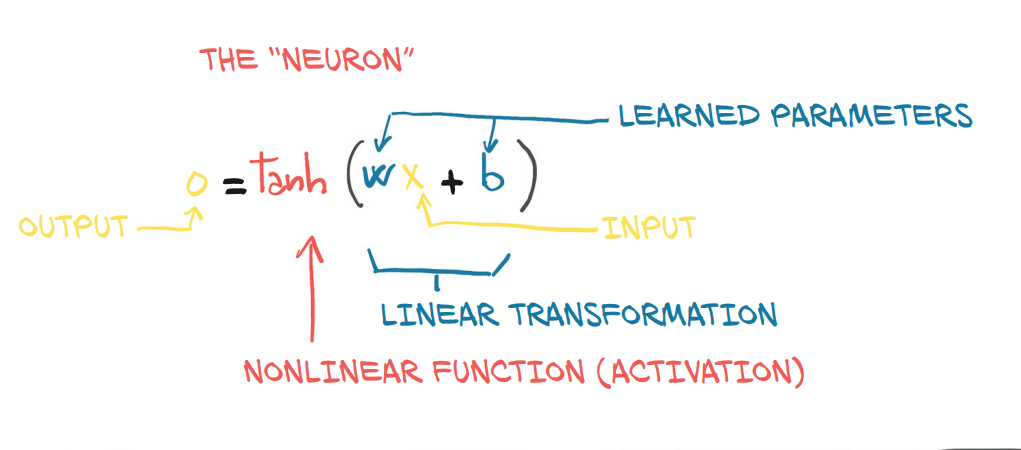

Mathematically, we can write this out as ***o= f(w * x + b),*** with x as our input, w our
weight or scaling factor, and b as our bias or offset. f is our activation function, set to
the hyperbolic tangent, or tanh function here. In general, x and, hence, o can be simple scalars, or vector-valued (meaning holding many scalar values); and similarly, w can be a single scalar or matrix, while b is a scalar or vector (the dimensionality of the
inputs and weights must match, however). In the latter case, the previous expression is
referred to as a layer of neurons, since it represents many neurons via the multidimensional weights and biases.

### 6.1.1 Composing a multilayer network

A multilayer neural network, as represented in figure, is made up of a composition
of functions like those we just discussed:

x_1 = f(w_0 * x + b_0)

x_2 = f(w_1 * x_1 + b_1)

x_3 = f(w_2 * x_2 + b_2)

...

y = f(w_n * x_n + b_n)

where the output of a layer of neurons is used as an input for the following layer.
Remember that w_0 here is a matrix, and x is a vector! Using a vector allows w_0 to
hold an entire layer of neurons, not just a single weight.

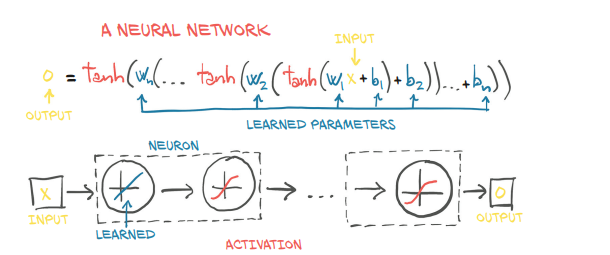

### 6.1.2 Understanding the error function

An important difference between our earlier linear model and what we’ll actually be
using for deep learning is the shape of the error function. Our linear model and
error-squared loss function had a convex error curve with a singular, clearly defined
minimum. If we were to use other methods, we could solve for the parameters minimizing the error function automatically and definitively. That means that our parameter updates were attempting to estimate that singular correct answer as best they could.

Neural networks do not have that same property of a convex error surface, even
when using the same error-squared loss function! There’s no single right answer for
each parameter we’re attempting to approximate. Instead, we are trying to get all of
the parameters, when acting in concert, to produce a useful output. Since that useful
output is only going to approximate the truth, there will be some level of imperfection.
Where and how imperfections manifest is somewhat arbitrary, and by implication the
parameters that control the output (and, hence, the imperfections) are somewhat
arbitrary as well. This results in neural network training looking very much like
parameter estimation from a mechanical perspective, but we must remember that the
theoretical underpinnings are quite different.

A big part of the reason neural networks have non-convex error surfaces is due to
the activation function. The ability of an ensemble of neurons to approximate a very
wide range of useful functions depends on the combination of the linear and nonlinear behavior inherent to each neuron.

### 6.1.3 All we need is activation

As we have seen, the simplest unit in (deep) neural networks is a linear operation
(scaling + offset) followed by an activation function. We already had our linear operation in our latest model—the linear operation was the entire model. The activation
function plays two important roles:
- In the inner parts of the model, it allows the output function to have different
slopes at different values—something a linear function by definition cannot do.
By trickily composing these differently sloped parts for many outputs, neural
networks can approximate arbitrary functions, as we will see in section 6.1.6
- At the last layer of the network, it has the role of concentrating the outputs of
the preceding linear operation into a given range.

Let’s talk about what the second point means. Pretend that we’re assigning a “good
doggo” score to images. Pictures of retrievers and spaniels should have a high score,
while images of airplanes and garbage trucks should have a low score. Bear pictures
should have a lowish score, too, although higher than garbage trucks.

The problem is, we have to define a “high score”: we’ve got the entire range of
float32 to work with, and that means we can go pretty high. Even if we say “it’s a 10-point
scale,” there’s still the issue that sometimes our model is going to produce a score of 11
out of 10. Remember that under the hood, it’s all sums of (w*x+b) matrix multiplications, and those won’t naturally limit themselves to a specific range of outputs.

**CAPPING THE OUTPUT RANGE**

We want to firmly constrain the output of our linear operation to a specific range so
that the consumer of this output doesn’t have to handle numerical inputs of puppies
at 12/10, bears at –10, and garbage trucks at –1,000.
One possibility is to just cap the output values: anything below 0 is set to 0, and anything above 10 is set to 10. That’s a simple activation function called torch.nn.Hardtanh
(https://pytorch.org/docs/stable/nn.html#hardtanh, but note that the default range
is –1 to +1).

**COMPRESSING THE OUTPUT RANGE**

Another family of functions that work well is torch.nn.Sigmoid, which includes 1 /
(1 + e ** -x), torch.tanh, and others that we’ll see in a moment. These functions
have a curve that asymptotically approaches 0 or –1 as x goes to negative infinity,
approaches 1 as x increases, and have a mostly constant slope at x == 0. Conceptually,
functions shaped this way work well because there’s an area in the middle of our linear function’s output that our neuron (which, again, is just a linear function followed
by an activation) will be sensitive to, while everything else gets lumped next to the
boundary values. As we can see in figure, our garbage truck gets a score of –0.97,
while bears and foxes and wolves end up somewhere in the –0.3 to 0.3 range

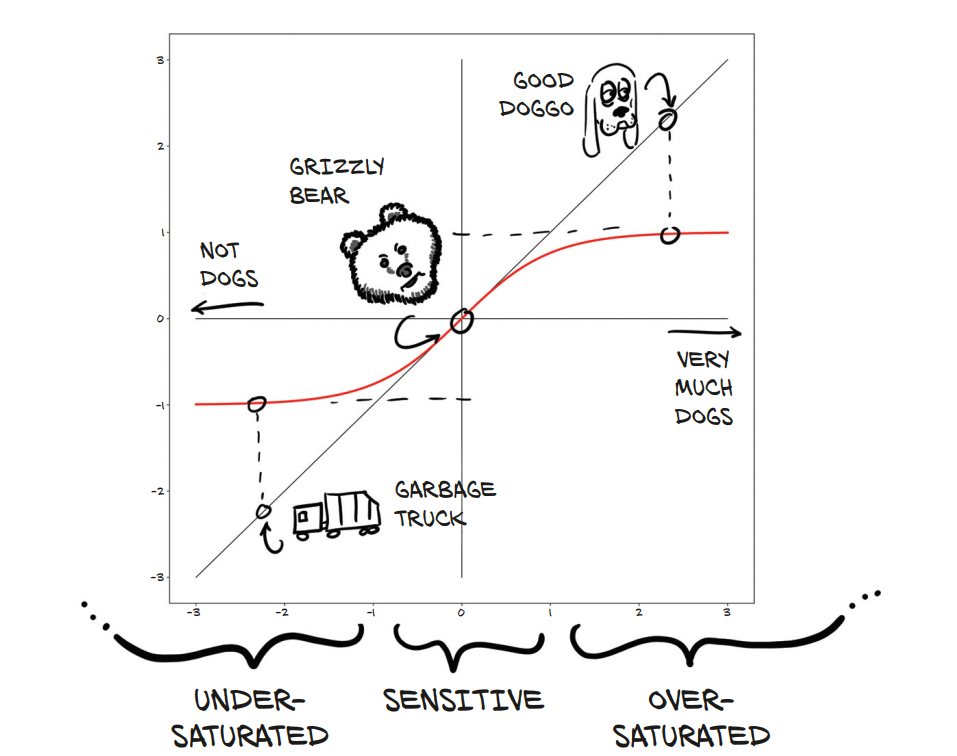

This results in garbage trucks being flagged as “not dogs,” our good dog mapping to
“clearly a dog,” and our bear ending up somewhere in the middle. In code, we can see
the exact values:

In [1]:
import math
math.tanh(-2.2)    # -> Garbage truck

-0.9757431300314515

In [2]:
math.tanh(0.2)    # -> Bear

0.197375320224904

In [3]:
math.tanh(2.2)    # -> Good Doggo

0.9757431300314515

With the bear in the sensitive range, small changes to the bear will result in a noticeable change to the result. For example, we could switch from a grizzly to a polar bear
(which has a vaguely more traditionally canine face) and see a jump up the Y-axis as
we slide toward the “very much a dog” end of the graph. Conversely, a koala bear
would register as less dog-like, and we would see a drop in the activated output. There
isn’t much we could do to the garbage truck to make it register as dog-like, though:
even with drastic changes, we might only see a shift from –0.97 to –0.8 or so.

### 6.1.4 More Activation Functions

There are quite a few activation functions, some of which are shown in below figure. In
the first column, we see the smooth functions Tanh and Softplus, while the second
column has “hard” versions of the activation functions to their left: Hardtanh and
ReLU. ReLU (for rectified linear unit) deserves special note, as it is currently considered
one of the best-performing general activation functions; many state-of-the-art results
have used it. The Sigmoid activation function, also known as the logistic function, was
widely used in early deep learning work but has since fallen out of common use
except where we explicitly want to move to the 0…1 range: for example, when the output should be a probability. Finally, the LeakyReLU function modifies the standard
ReLU to have a small positive slope, rather than being strictly zero for negative inputs
(typically this slope is 0.01, but it’s shown here with slope 0.1 for clarity).

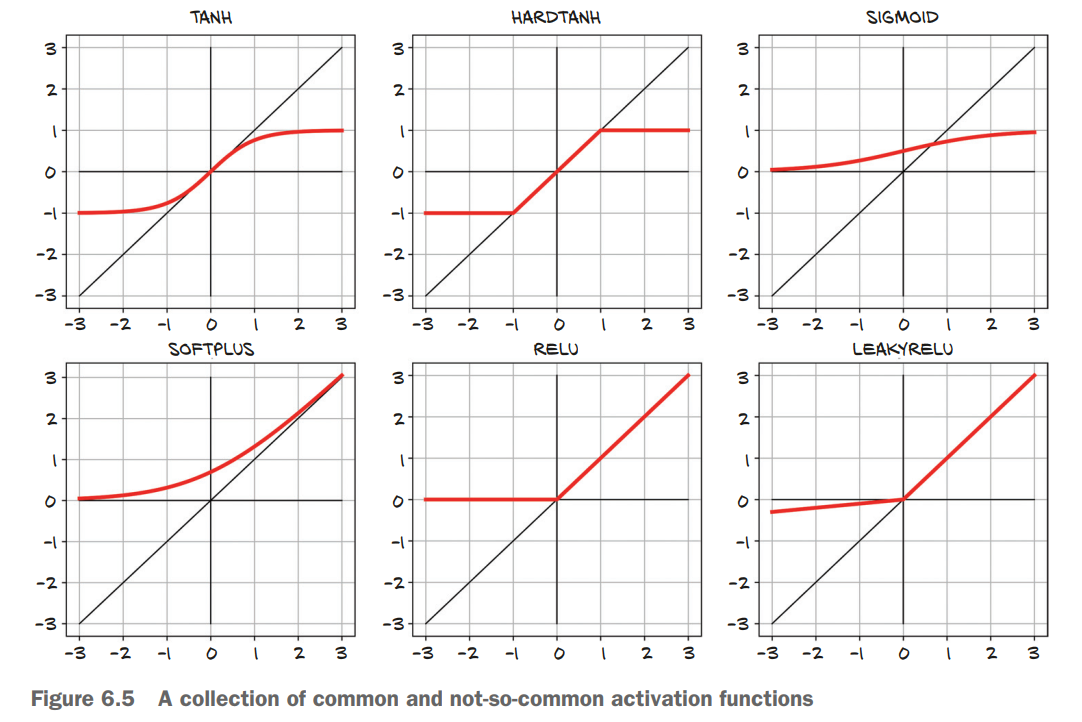

### 6.1.5 Choosing the best activation function

Activation functions are curious, because with such a wide variety of proven successful
ones (many more than shown in figure), it’s clear that there are few, if any, strict
requirements. As such, we’re going to discuss some generalities about activation functions that can probably be trivially disproved in the specific. That said, by definition,
activation functions:

- Are nonlinear. Repeated applications of (w*x+b) without an activation function
results in a function of the same (affine linear) form. The nonlinearity allows
the overall network to approximate more complex functions.
- Are differentiable, so that gradients can be computed through them. Point discontinuities, as we can see in Hardtanh or ReLU, are fine.

Without these characteristics, the network either falls back to being a linear model or
becomes difficult to train.
The following are true for the functions:

- They have at least one sensitive range, where nontrivial changes to the input
result in a corresponding nontrivial change to the output. This is needed for
training.
- Many of them have an insensitive (or saturated) range, where changes to the
input result in little or no change to the output

Often (but far from universally so), the activation function will have at least one of
these:
- A lower bound that is approached (or met) as the input goes to negative infinity
- A similar-but-inverse upper bound for positive infinity

Thinking of what we know about how backpropagation works, we can figure out that
the errors will propagate backward through the activation more effectively when the
inputs are in the response range, while errors will not greatly affect neurons for which the input is saturated (since the gradient will be close to zero, due to the flat area
around the output).

Put together, all this results in a pretty powerful mechanism: we’re saying that in a
network built out of linear + activation units, when different inputs are presented to
the network, (a) different units will respond in different ranges for the same inputs,
and (b) the errors associated with those inputs will primarily affect the neurons operating in the sensitive range, leaving other units more or less unaffected by the learning process. In addition, thanks to the fact that derivatives of the activation with
respect to its inputs are often close to 1 in the sensitive range, estimating the parameters of the linear transformation through gradient descent for the units that operate
in that range will look a lot like the linear fit we have seen previously.

We are starting to get a deeper intuition for how joining many linear + activation
units in parallel and stacking them one after the other leads us to a mathematical
object that is capable of approximating complicated functions. Different combinations of units will respond to inputs in different ranges, and those parameters for
those units are relatively easy to optimize through gradient descent, since learning will
behave a lot like that of a linear function until the output saturates.

### 6.1.6 What learning means for a neural network

Building models out of stacks of linear transformations followed by differentiable activations leads to models that can approximate highly nonlinear processes and whose
parameters we can estimate surprisingly well through gradient descent. This remains
true even when dealing with models with millions of parameters. What makes using
deep neural networks so attractive is that it saves us from worrying too much about the
exact function that represents our data—whether it is quadratic, piecewise polynomial, or something else. With a deep neural network model, we have a universal
approximator and a method to estimate its parameters. This approximator can be customized to our needs, in terms of model capacity and its ability to model complicated
input/output relationships, just by composing simple building blocks. We can see
some examples of this in figure below:


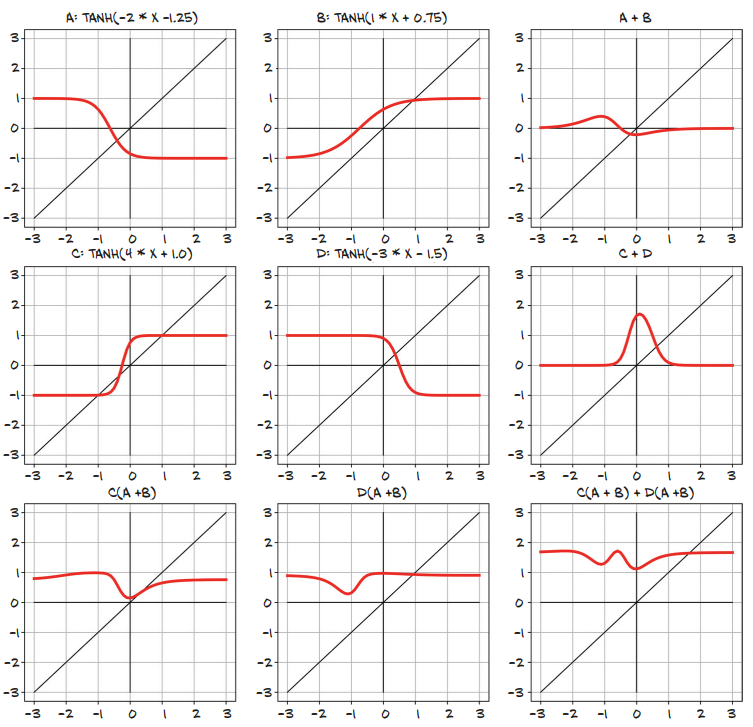

The four upper-left graphs show four neurons—A, B, C, and D—each with its own
(arbitrarily chosen) weight and bias. Each neuron uses the Tanh activation function
with a min of –1 and a max of 1. The varied weights and biases move the center point
and change how drastically the transition from min to max happens, but they clearly
all have the same general shape. The columns to the right of those show both pairs of
neurons added together (A + B and then C + D). Here, we start to see some interesting properties that mimic a single layer of neurons. A + B shows a slight S curve, with
the extremes approaching 0, but both a positive bump and a negative bump in the
middle. Conversely, C + D has only a large positive bump, which peaks at a higher
value than our single-neuron max of 1.

In the third row, we begin to compose our neurons as they would be in a two-layer network. Both C(A + B) and D(A + B) have the same positive and negative bumps that A + B
shows, but the positive peak is more subtle. The composition of C(A + B) + D(A + B) shows a new property: two clearly negative bumps, and possibly a very subtle second positive peak as well, to the left of the main area of interest. All this with only four neurons
in two layers!

Again, these neurons’ parameters were chosen only to have a visually interesting
result. Training consists of finding acceptable values for these weights and biases so
that the resulting network correctly carries out a task, such as predicting likely temperatures given geographic coordinates and time of the year. By carrying out a task successfully, we mean obtaining a correct output on unseen data produced by the same
data-generating process used for training data. A successfully trained network,
through the values of its weights and biases, will capture the inherent structure of the
data in the form of meaningful numerical representations that work correctly for previously unseen data.

Let’s take another step in our realization of the mechanics of learning: deep neural
networks give us the ability to approximate highly nonlinear phenomena without having an explicit model for them. Instead, starting from a generic, untrained model, we
specialize it on a task by providing it with a set of inputs and outputs and a loss function
from which to backpropagate. Specializing a generic model to a task using examples is
what we refer to as learning, because the model wasn’t built with that specific task in
mind—no rules describing how that task worked were encoded in the model.

## 6.2 The PyTorch nn nodule

PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch parlance (such building
blocks are often referred to as layers in other frameworks). A PyTorch module is a
Python class deriving from the nn.Module base class. A module can have one or more
Parameter instances as attributes, which are tensors whose values are optimized
during the training process (think w and b in our linear model). A module can also
have one or more submodules (subclasses of nn.Module) as attributes, and it will be
able to track their parameters as well.

**NOTE** &ensp; The submodules must be top-level attributes, not buried inside list or
dict instances! Otherwise, the optimizer will not be able to locate the submodules (and, hence, their parameters). For situations where your model
requires a list or dict of submodules, PyTorch provides nn.ModuleList and
nn.ModuleDict.

Unsurprisingly, we can find a subclass of nn.Module called nn.Linear, which applies
an affine transformation to its input (via the parameter attributes weight and bias)
and is equivalent to what we implemented earlier in our thermometer experiments.
We’ll now start precisely where we left off and convert our previous code to a form
that uses nn.

### 6.2.1 Using __call __ rather than forward

All PyTorch-provided subclasses of nn.Module have their __ call__ method defined.
This allows us to instantiate an nn.Linear and call it as if it was a function, like so:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

C:\Users\muhammad.adil\Miniconda3\envs\sahi\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
t_un_val = torch.tensor([5.8200, 3.3900])
linear_model = nn.Linear(2, 2)
linear_model(t_un_val)

tensor([ 1.6485, -0.8319], grad_fn=<AddBackward0>)

The constructor to nn.Linear accepts three arguments: the
number of input features, the number of output features, and whether the linear
model includes a bias or not (defaulting to True, here):

The number of features in our case just refers to the size of the input and the output
tensor for the module, so 1 and 1. If we used both temperature and barometric pressure as input, for instance, we would have two features in input and one feature in output. As we will see, for more complex models with several intermediate modules, the
number of features will be associated with the capacity of the model.

In [6]:
linear_model.weight

Parameter containing:
tensor([[-0.0250,  0.3519],
        [-0.1096,  0.1227]], requires_grad=True)

We can call the module with some input:


In [7]:
linear_model = nn.Linear(1,1)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([-0.2483], grad_fn=<AddBackward0>)

Although PyTorch lets us get away with it, we don’t actually provide an input with the
right dimensionality. We have a model that takes one input and produces one output,
but PyTorch nn.Module and its subclasses are designed to do so on multiple samples at
the same time. To accommodate multiple samples, modules expect the zeroth dimension of the input to be the number of samples in the batch. We encountered this concept in chapter 4, when we learned how to arrange real-world data into tensors.

**BATCHING INPUTS** <br>
Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example:

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483],
        [-0.2483]], grad_fn=<AddmmBackward0>)

Let’s dig into what’s going on here, with figure 6.7 showing a similar situation with
batched image data. Our input is B × C × H × W with a batch size of 3 (say, images
of a dog, a bird, and then a car), three channel dimensions (red, green, and blue),
and an unspecified number of pixels for height and width. As we can see, the output is a tensor of size B × Nout, where Nout is the number of output features: four, in
this case.

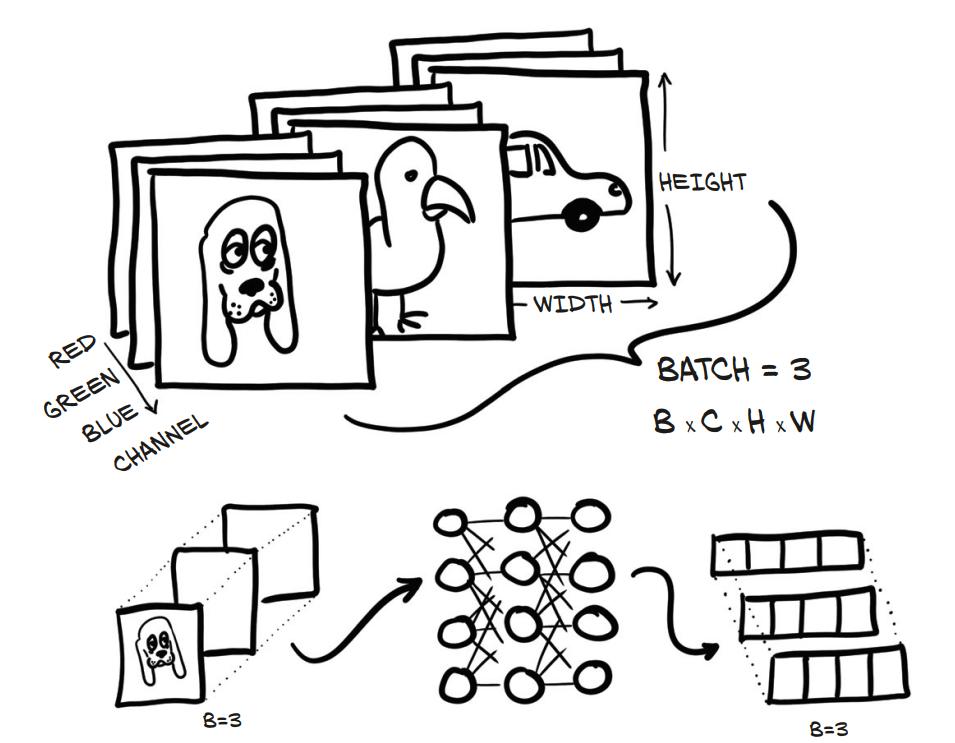

**OPTIMIZING BATCHES** <br> The reason we want to do this batching is multifaceted. One big motivation is to make
sure the computation we’re asking for is big enough to saturate the computing
resources we’re using to perform the computation. GPUs in particular are highly parallelized, so a single input on a small model will leave most of the computing units idle.
By providing batches of inputs, the calculation can be spread across the otherwise-idle
units, which means the batched results come back just as quickly as a single result
would. Another benefit is that some advanced models use statistical information from
the entire batch, and those statistics get better with larger batch sizes.

That’s exactly what we need to do to switch to using nn.Linear. We reshape our B
inputs to B × Nin, where Nin is 1. That is easily done with unsqueeze:

In [10]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

In [11]:
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_c.shape

torch.Size([11, 1])

We’re done; let’s update our training code. First, we replace our handmade model
with nn.Linear(1,1), and then we need to pass the linear model parameters to the
optimizer:

In [12]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
linear_model.parameters(),
lr=1e-2)

Earlier, it was our responsibility to create parameters and pass them as the first argument to optim.SGD. Now we can use the parameters method to ask any nn.Module for
a list of parameters owned by it or any of its submodules:

In [13]:
linear_model.parameters()

<generator object Module.parameters at 0x00000266CB1C43C0>

In [14]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.1211]], requires_grad=True),
 Parameter containing:
 tensor([0.5905], requires_grad=True)]

We can already figure out what happens in the training loop. The optimizer is provided with a list of tensors that were defined with requires_grad = True—all Parameters
are defined this way by definition, since they need to be optimized by gradient descent.
When training_loss.backward() is called, grad is accumulated on the leaf nodes of the
graph, which are precisely the parameters that were passed to the optimizer.
At this point, the SGD optimizer has everything it needs. When optimizer.step()
is called, it will iterate through each Parameter and change it by an amount proportional to what is stored in its grad attribute. Pretty clean design.

Let’s take a look a the training loop now:

In [15]:
def model(t_u, w, b):
    return (t_u * w + b)

def loss_fn(t_p, t_c):
    squarred_diff = (t_p-t_c) ** 2
    return squarred_diff.mean()

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(n_epochs):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        print('loss_train', loss_train)
        print('loss_val', loss_val)
        if epoch ==0 or epoch%1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f}, 'f"Validation loss {loss_val.item():.4f}")

            

In [17]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

It hasn’t changed practically at all, except that now we don’t pass params explicitly to
model since the model itself holds its Parameters internally.

There’s one last bit that we can leverage from torch.nn: the loss. Indeed, nn comes
with several common loss functions, among them nn.MSELoss (MSE stands for Mean
Square Error), which is exactly what we defined earlier as our loss_fn. Loss functions
in nn are still subclasses of nn.Module, so we will create an instance and call it as a
function. In our case, we get rid of the handwritten loss_fn and replace it:

In [18]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
linear_model, optimizer

(Linear(in_features=1, out_features=1, bias=True),
 SGD (
 Parameter Group 0
     dampening: 0
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## 6.3 Finally a neural network

It’s been a long journey—there has been a lot to explore for these 20-something lines
of code we require to define and train a model. Hopefully by now the magic involved
in training has vanished and left room for the mechanics. What we learned so far will
allow us to own the code we write instead of merely poking at a black box when things
get more complicated.

 There’s one last step left to take: replacing our linear model with a neural network
as our approximating function. We said earlier that using a neural network will not
result in a higher-quality model, since the process underlying our calibration problem
was fundamentally linear. However, it’s good to make the leap from linear to neural
network in a controlled environment so we won’t feel lost later.

### 6.3.1  Replacing the linear model <br>


We are going to keep everything else fixed, including the loss function, and only redefine model. Let’s build the simplest possible neural network: a linear module, followed
by an activation function, feeding into another linear module. The first linear + activation layer is commonly referred to as a hidden layer for historical reasons, since its outputs are not observed directly but fed into the output layer. While the input and output
of the model are both of size 1 (they have one input and one output feature), the size
of the output of the first linear module is usually larger than 1. Recalling our earlier
explanation of the role of activations, this can lead different units to respond to different
ranges of the input, which increases the capacity of our model. The last linear layer will
take the output of activations and combine them linearly to produce the output value.

 There is no standard way to depict neural networks. Figure below shows two ways that
seem to be somewhat prototypical: the left side shows how our network might be
depicted in basic introductions, whereas a style similar to that on the right is often
used in the more advanced literature and research papers. It is common to make diagram blocks that roughly correspond to the neural network modules PyTorch offers
(though sometimes things like the Tanh activation layer are not explicitly shown).
Note that one somewhat subtle difference between the two is that the graph on the
left has the inputs and (intermediate) results in the circles as the main elements. On
the right, the computational steps are more prominent.

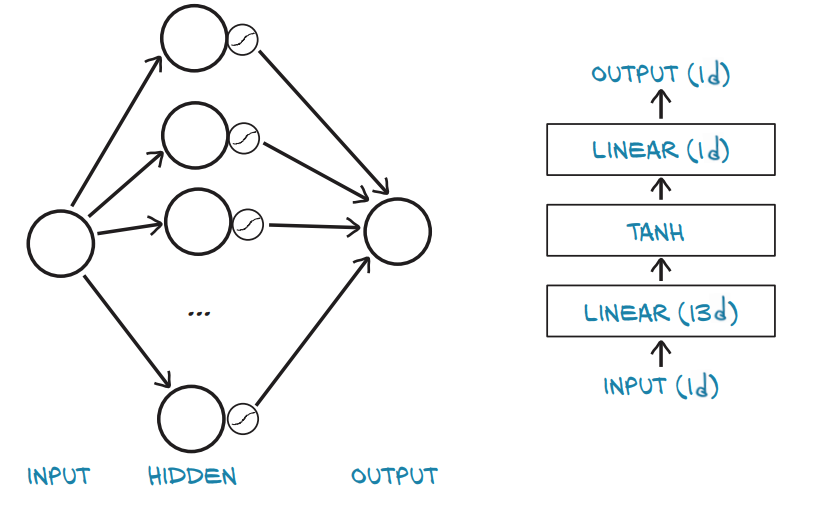

nn provides a simple way to concatenate modules through the nn.Sequential
container:

In [19]:
seq_model = nn.Sequential(
              nn.Linear(1, 13),
              nn.Tanh(),
              nn.Linear(13, 1)
                )
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified
as an argument of nn.Sequential, passes intermediate outputs to subsequent modules, and produces the output returned by the last module. The model fans out from
1 input feature to 13 hidden features, passes them through a tanh activation, and linearly combines the resulting 13 numbers into 1 output feature.

### 6.3.2 Inspecting the parameters <br> 
Calling model.parameters() will collect weight and bias from both the first and second linear modules. It’s instructive to inspect the parameters in this case by printing their shapes:

In [20]:
list(seq_model.parameters())

[Parameter containing:
 tensor([[-0.0835],
         [-0.7762],
         [ 0.7874],
         [-0.7492],
         [ 0.7972],
         [-0.1767],
         [-0.1170],
         [ 0.5811],
         [ 0.5099],
         [-0.3587],
         [ 0.8004],
         [ 0.0158],
         [-0.5808]], requires_grad=True),
 Parameter containing:
 tensor([-0.7952, -0.8511,  0.9578,  0.4502,  0.3786, -0.9170,  0.3055,  0.3761,
          0.7427,  0.9555,  0.4016, -0.1724,  0.3612], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0721, -0.0025, -0.0684, -0.1227, -0.0269,  0.0753,  0.0761, -0.2744,
          -0.1758, -0.1249, -0.2384,  0.0657, -0.1340]], requires_grad=True),
 Parameter containing:
 tensor([0.1582], requires_grad=True)]

In [21]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

These are the tensors that the optimizer will get. Again, after we call model.backward(),
all parameters are populated with their grad, and the optimizer then updates their values accordingly during the optimizer.step() call. Not that different from our previous
linear model, eh? After all, they’re both differentiable models that can be trained using
gradient descent

A few notes on parameters of nn.Modules. When inspecting parameters of a model
made up of several submodules, it is handy to be able to identify parameters by name.
There’s a method for that, called named_parameters:

In [22]:
[param.shape for param in seq_model.parameters()], seq_model

([torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])],
 Sequential(
   (0): Linear(in_features=1, out_features=13, bias=True)
   (1): Tanh()
   (2): Linear(in_features=13, out_features=1, bias=True)
 ))

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param, param.shape)

0.weight Parameter containing:
tensor([[-0.0835],
        [-0.7762],
        [ 0.7874],
        [-0.7492],
        [ 0.7972],
        [-0.1767],
        [-0.1170],
        [ 0.5811],
        [ 0.5099],
        [-0.3587],
        [ 0.8004],
        [ 0.0158],
        [-0.5808]], requires_grad=True) torch.Size([13, 1])
0.bias Parameter containing:
tensor([-0.7952, -0.8511,  0.9578,  0.4502,  0.3786, -0.9170,  0.3055,  0.3761,
         0.7427,  0.9555,  0.4016, -0.1724,  0.3612], requires_grad=True) torch.Size([13])
2.weight Parameter containing:
tensor([[ 0.0721, -0.0025, -0.0684, -0.1227, -0.0269,  0.0753,  0.0761, -0.2744,
         -0.1758, -0.1249, -0.2384,  0.0657, -0.1340]], requires_grad=True) torch.Size([1, 13])
2.bias Parameter containing:
tensor([0.1582], requires_grad=True) torch.Size([1])


The name of each module in Sequential is just the ordinal with which the module
appears in the arguments. Interestingly, Sequential also accepts an OrderedDict,in
which we can name each module passed to Sequential:

In [24]:
from collections import OrderedDict as od

In [25]:
seq_model = nn.Sequential(od([
    ('hidden_linear', nn.Linear(1, 9)),
    ('hidden_activation', nn.Tanh()),
    ('hidden_output', nn.Linear(9, 1))
]))

This allows us to get more explanatory names for submodules:

In [26]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([9, 1])
hidden_linear.bias torch.Size([9])
hidden_output.weight torch.Size([1, 9])
hidden_output.bias torch.Size([1])


This is more descriptive; but it does not give us more flexibility in the flow of data
through the network, which remains a purely sequential pass-through—the
nn.Sequential is very aptly named. We will see how to take full control of the processing of input data by subclassing nn.Module ourselves in future.

 We can also access a particular Parameter by using submodules as attributes:


In [27]:
seq_model.hidden_activation

Tanh()